In [48]:
import json
from pprint import pprint
from collections import Counter
import re
import requests
import matplotlib.pyplot as plt
import time
import pandas as pd

with open("../public/ligifyDB.json", "r") as f:
    data = json.load(f)

# Count number of unique small molecules
unique_regs = len(data)
print(f"Unique regulators: {unique_regs}")

# Extract SMILES strings
smiles_list = []
for entry in data:
    if "candidate_ligands" in entry:
        for ligand in entry["candidate_ligands"]:
            if "smiles" in ligand:
                smiles_list.append(ligand["smiles"])

# Convert to DataFrame for convenience
df = pd.DataFrame(smiles_list, columns=["SMILES"])

# Count unique SMILES
unique_smiles = df["SMILES"].nunique()

print(f"Total SMILES entries: {len(df)}")
print(f"Unique SMILES entries: {unique_smiles}")

    

Unique regulators: 3164
Total SMILES entries: 18898
Unique SMILES entries: 1374


START OF THE ORGANISM SECTION

In [ ]:
# MOST COMMON ORGANISMS

START OF THE REGULATOR SECTION

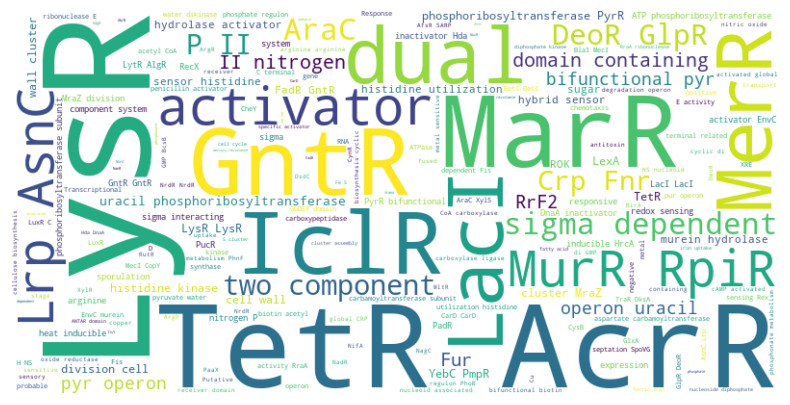

In [24]:
# CREATE A WORD CLOUD FROM ANNOTATIONS

# Get all regulators annotations
annotations = [i["annotation"] for i in data]

# Extract and count all the “words”
words = [
    w
    for ann in annotations
    for w   in re.findall(r'\b\w+\b', ann)
]
counts = Counter(words)

# Combine all individual annotation words into one string, and remove non-descriptive labels
annos = "".join(i+" " for i in words if i not in ["transcriptional", "regulator", "family", "transcription", "factor", "DNA", "response", "helix",\
    "regulatory", "protein", "repressor", "binding", "putative", "winged", "HTH", "type", "turn"])


# # Make a word cloud
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(annos)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off") # Turn off axis labels
plt.show()


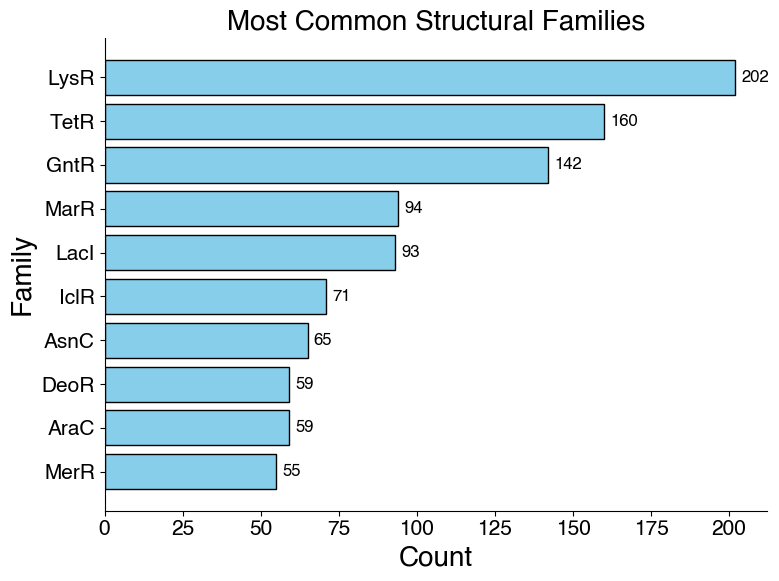

In [46]:
# CREATE A BAR PLOT WITH MOST COMMON FAMILIES

# created from filtering 
families = {
    'LysR': 202, 'TetR': 160, 'GntR': 142, 'MarR': 94, 'LacI': 93, 'IclR': 71, 'AsnC': 65, 'DeoR': 59, 'AraC': 59, 'MerR': 55
    }

# Sort dictionary (optional, for cleaner plot)
sorted_data = dict(sorted(families.items(), key=lambda x: x[1], reverse=True))

# Extract keys and values
names = list(sorted_data.keys())
values = list(sorted_data.values())

# Modern font settings
plt.rcParams.update({
    "font.family": "Helvetica",  # swap with "Helvetica" if available
    "font.size": 13
})

# Plot
plt.figure(figsize=(8,6))
bars = plt.barh(names, values, color="skyblue", edgecolor="black")  # add black outline

plt.xlabel("Count", fontsize=20, fontweight="bold")
plt.ylabel("Family", fontsize=20, fontweight="bold")
plt.title("Most Common Structural Families", fontsize=20, fontweight="bold")

# Increase tick label size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Add value labels at the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 2,              # shift a little right of the bar
             bar.get_y() + bar.get_height()/2,
             str(width),
             va="center", ha="left", fontsize=12, weight="bold")

# Remove top and right spines
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.gca().invert_yaxis()  # largest on top
plt.tight_layout()

# Save as PNG directly into the public folder
plt.savefig("../public/Content_Stats/Common_Families.png", format="png", dpi=500)

plt.show()

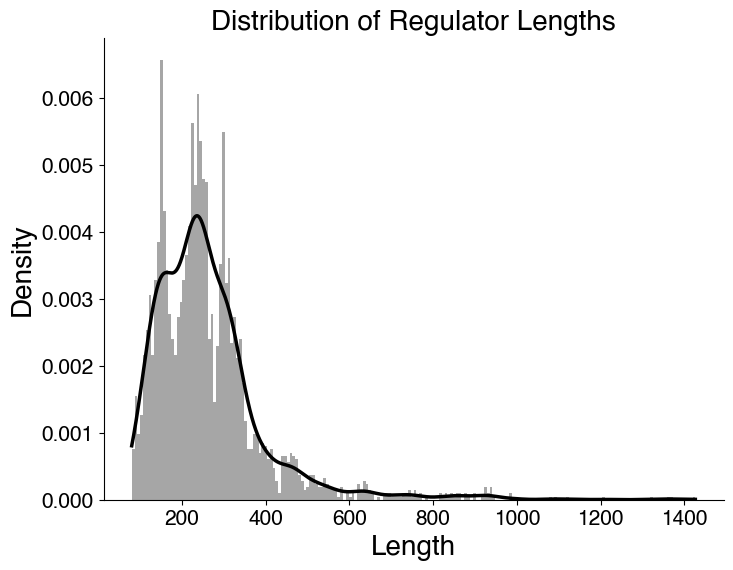

In [47]:
# HISTOGRAM DISTRIBUTION OF REGULATOR LENGTHS

import numpy as np
from scipy.stats import gaussian_kde

# get lengths
reg_lengths = [len(i["protein_seq"]) for i in data]

# Convert to numpy array
reg_lengths = np.array(reg_lengths)

# Fit Gaussian KDE
kde = gaussian_kde(reg_lengths)
x_vals = np.linspace(reg_lengths.min(), reg_lengths.max(), 10000)  # smooth x range
y_vals = kde(x_vals)

# Modern font settings
plt.rcParams.update({
    "font.family": "Helvetica",  # swap with "Helvetica" if available
    "font.size": 13
})

# Plot
plt.figure(figsize=(8,6))

# Plot smooth KDE curve
plt.plot(x_vals, y_vals, color="black", linewidth=2.5)

# Optionally also plot the histogram as background
plt.hist(reg_lengths, bins=200, color="gray", density=True, alpha=0.7)

plt.xlabel('Length', fontsize=20, fontweight="bold")
plt.ylabel('Density', fontsize=20, fontweight="bold")
plt.title("Distribution of Regulator Lengths", fontsize=20, fontweight="bold")

# Increase tick label size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Remove top and right spines
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Save as PNG directly into the public folder
plt.savefig("../public/Content_Stats/Regulator_Lengths.png", format="png", dpi=500)

plt.show()

START OF THE PROMOTER/OPERON SECTION

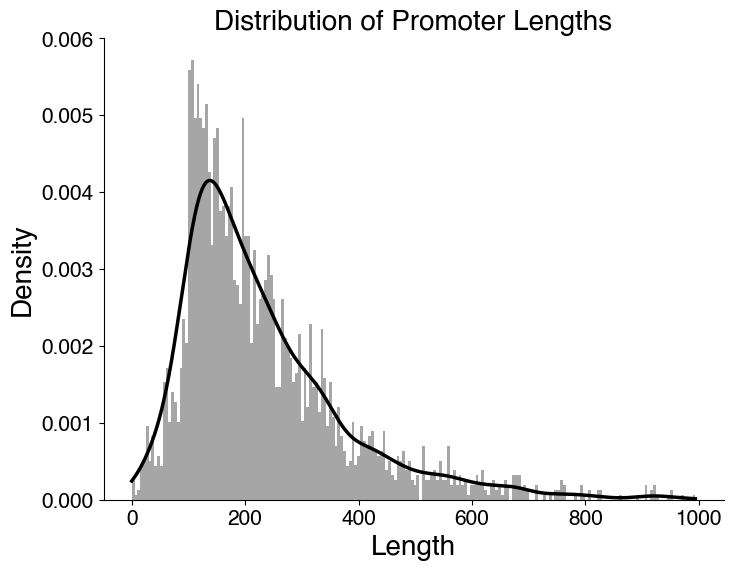

In [76]:
# LENGTH OF PREDICTED PROMOTER

promoter_lengths = [len(i['protein']['context']['promoter']["regulated_seq"]) for k in data for i in k['data'][0]]

# Create a new figure
plt.figure()                      
plt.hist(promoter_lengths, bins=100, density=True)
plt.xlabel('Predicted promoter length')
plt.ylabel('Density')
plt.title('Lengths of predicted promoters')
plt.show()

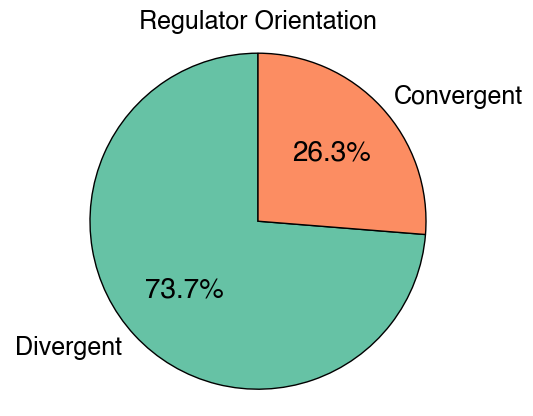

In [74]:
# DIRECTION OF REGULATOR EXPRESSION

reg_direction = [i['protein']['context']['promoter']["reg_type"] for i in data]


total = len(reg_direction)
divergent = int((len([i for i in reg_direction if i == 1])/total)*100)
convergent = int((len([i for i in reg_direction if i == 2])/total)*100)

# Data for the pie chart
sizes = [divergent, convergent]  
labels = ['Divergent', 'Convergent']
colors = plt.cm.Set2.colors[:2]

# custom function for autopct font size
def make_autopct(values):
    def my_autopct(pct):
        return f"{pct:.1f}%"  # format
    return my_autopct

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct=make_autopct(sizes),
    startangle=90,
    colors=colors,
    wedgeprops={"edgecolor": "black", "linewidth": 1},
    textprops={"fontweight": "bold", "fontsize": 18}  # labels
)

# make autopct (numbers) bigger
for autotext in autotexts:
    autotext.set_fontsize(20)   # bigger font
    autotext.set_weight("bold") # optional bold

plt.title("Regulator Orientation", fontsize=18, weight="bold")
plt.axis("equal")

# Save as PNG directly into the public folder
plt.savefig("../public/Content_Stats/Regulator_Orientation.png", format="png", dpi=500)

plt.show()

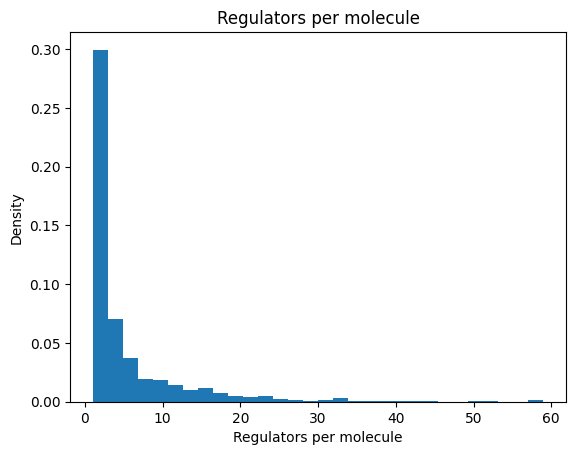

In [55]:
# Regulators per molecule (distribution)

regs_per_mol = [len(i['data'][0]) for i in data]

# Create a new figure
plt.figure()                      
plt.hist(regs_per_mol, bins=30, density=True)
plt.xlabel('Regulators per molecule')
plt.ylabel('Density')
plt.title('Regulators per molecule')
plt.show()

START OF THE RANKING SECTION

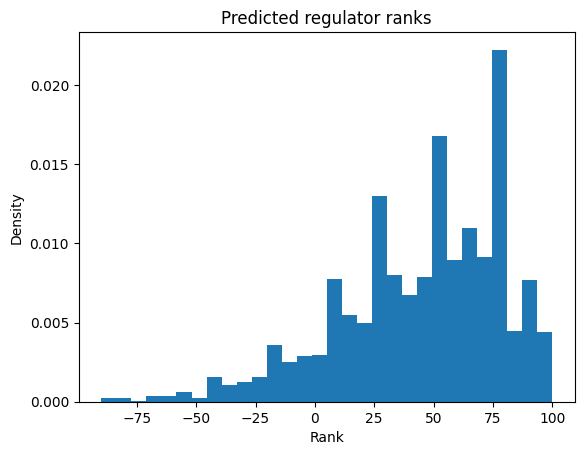

In [94]:

# Rank

ranks = [i['rank']['rank'] for k in data for i in k['data'][0]]

# Create a new figure
plt.figure()                      
plt.hist(ranks, bins=30, density=True)
plt.xlabel('Rank')
plt.ylabel('Density')
plt.title('Predicted regulator ranks')
plt.show()

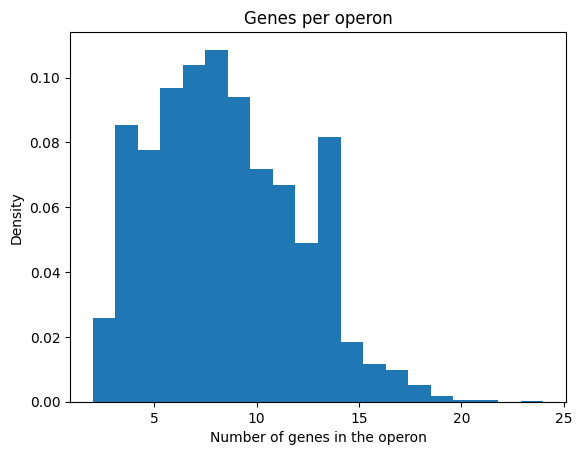

In [89]:
# Genes in each operon

genes_per_operon = [len(i['protein']['context']['operon']) for k in data for i in k['data'][0]]

# Create a new figure
plt.figure()                      
plt.hist(genes_per_operon, bins=20, density=True)
plt.xlabel('Number of genes in the operon')
plt.ylabel('Density')
plt.title('Genes per operon')
plt.show()

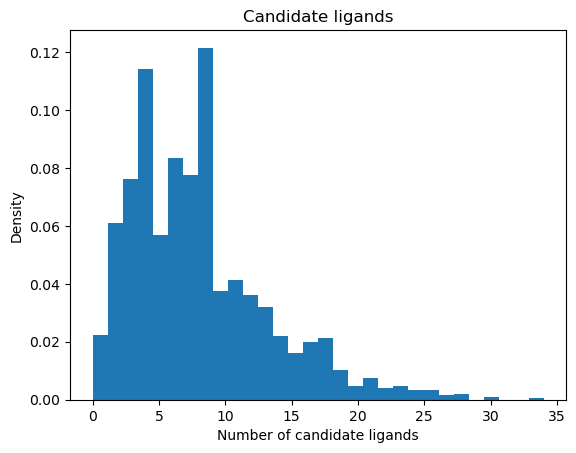

In [30]:
# Number of candidate ligands

candidate_ligands = [len(i["candidate_ligands"]) for k in data for i in k['data'][0]]

# Create a new figure
plt.figure()                      
plt.hist(candidate_ligands, bins=30, density=True)
plt.xlabel('Number of candidate ligands')
plt.ylabel('Density')
plt.title('Candidate ligands')
plt.show()

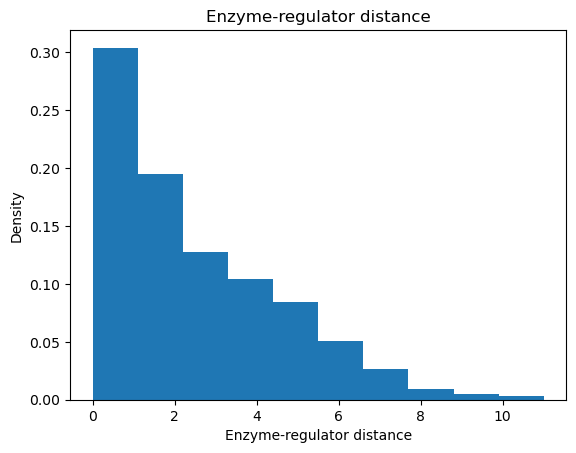

In [35]:
# Enzyme-regulator distance

enz_reg_dist = [i['rank']['metrics']['Enzyme-regulator distance']["Value"] for k in data for i in k['data'][0]]

# Create a new figure
plt.figure()                      
plt.hist(enz_reg_dist, bins=10, density=True)
plt.xlabel('Enzyme-regulator distance')
plt.ylabel('Density')
plt.title('Enzyme-regulator distance')
plt.show()